In [67]:
import pandas as pd

In [68]:
df = pd.read_csv("dataset/diabetes.csv")

In [69]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [70]:
df.shape

(768, 9)

In [71]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [72]:
import seaborn as sns
import matplotlib as plt


<Axes: >

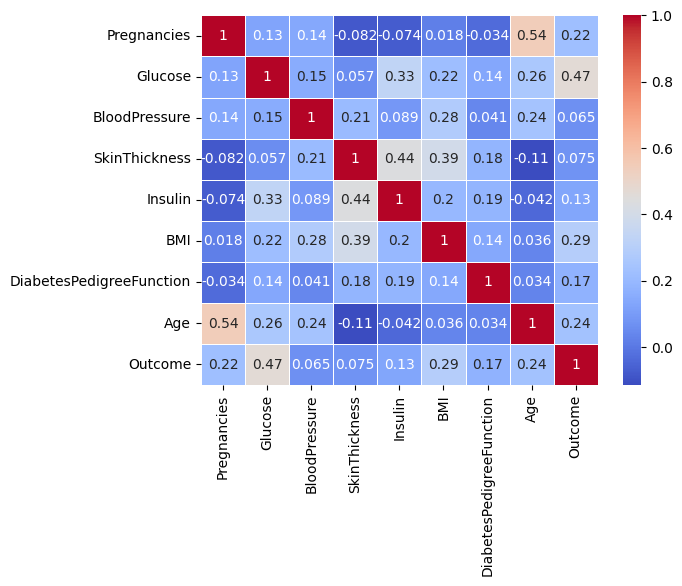

In [73]:
sns.heatmap(df.corr(), annot=True, cmap='coolwarm',linewidths=0.5)

In [74]:
df.describe().columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

In [75]:
X = df[['Pregnancies','Glucose','Insulin','BMI','Age']]
y = df['Outcome']

<Axes: xlabel='Outcome', ylabel='count'>

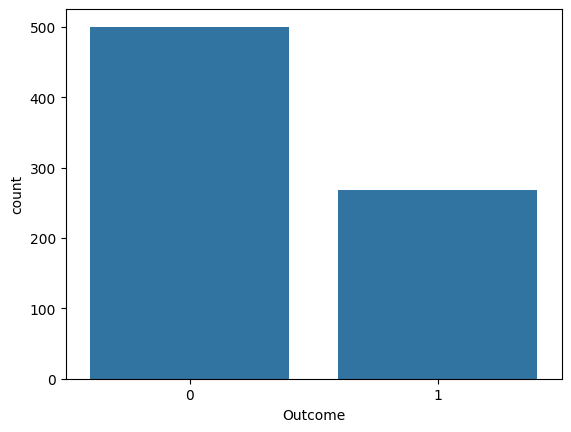

In [76]:
sns.countplot(x='Outcome', data=df)

In [77]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42  #train and test sets maintain the same class distribution 
)

In [78]:
from sklearn.preprocessing import StandardScaler

scalar = StandardScaler() #normalise the feature mean = 0, standard-deviation = 1
X_train = scalar.fit_transform(X_train)
X_test = scalar.transform(X_test)

In [79]:
import torch

In [80]:
X_train_t = torch.tensor(X_train, dtype=torch.float32) #convert numpy array to tensors 
y_train_t = torch.tensor(y_train.to_numpy(), dtype=torch.long)

X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_test_t = torch.tensor(y_test.to_numpy(), dtype=torch.long)

In [81]:
class_counts = torch.bincount(y_train_t) #calculate the output class count
class_weights = 1.0 / class_counts.float() #calculate the weights

print("Class counts:", class_counts)
print("Class weights:", class_weights)


Class counts: tensor([400, 214])
Class weights: tensor([0.0025, 0.0047])


In [82]:
from torch.utils.data import DataLoader, TensorDataset, WeightedRandomSampler

sample_weights = class_weights[y_train_t] #assigning each sample its weights 

sampler = WeightedRandomSampler( #Rebalances sampling
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)

count_neg = (y_train == 0).sum()
count_pos = (y_train == 1).sum()

pos_weight = torch.tensor([count_neg / count_pos], dtype=torch.float32)


In [83]:
train_dataset = TensorDataset(X_train_t, y_train_t) # TensorDataset pairs X and y together so DataLoader can load them in batches
test_dataset = TensorDataset(X_test_t, y_test_t)

train_loader = DataLoader( train_dataset, batch_size=32, sampler=sampler)
test_loader = DataLoader( test_dataset, batch_size=32, shuffle=False)

In [ ]:
import torch
import torch.nn as nn

class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.net = nn.Sequential(
            # nn.Linear(X_train.shape[1],32),
            # nn.ReLU(),
            # nn.Linear(32,16),
            # nn.ReLU(),
            # nn.Linear(16,1)

            
            nn.Linear(X_train.shape[1], 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(32, 1)
        )
        
    def forward(self, X):
        return self.net(X)
model = Net()

In [85]:
#criterion = nn.CrossEntropyLoss(weight=class_weights)  # to punish the model in the mistakes
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight) #

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [86]:
epochs = 500   #training loop
model.train()

train_loss = []


for epoch in range(epochs):
    epoch_loss = 0

    for Xb, yb in train_loader:
        optimizer.zero_grad()
        out = model(Xb).squeeze()
        loss = criterion(out,yb.float())
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
    train_loss.append(epoch_loss)

    if epoch % 100 == 0:
        print(f"Epoch: {epoch}, loss = {epoch_loss:.4f}")

Epoch: 0, loss = 18.7638
Epoch: 100, loss = 12.1212
Epoch: 200, loss = 11.9847
Epoch: 300, loss = 11.0257
Epoch: 400, loss = 12.8474


In [90]:
model.eval()
y_pred_list = []
val_losses = []
val_epoch_loss = 0

with torch.no_grad():
    for Xb, yb in test_loader:
        # outputs = model(Xb)   #normal way
        # probs = torch.softmax(outputs, dim=1)
        # preds = torch.argmax(probs, dim=1)
        # y_pred_list.extend(preds.cpu().numpy())

        outputs = model(Xb).squeeze()
        preds = (outputs > 0).long()  # For binary classification with BCEWithLogitsLoss
        y_pred_list.extend(preds.cpu().numpy())
        loss = criterion(outputs, yb.float())
        val_epoch_loss += loss.item()

val_losses.append(val_epoch_loss)
model.train()

Net(
  (net): Sequential(
    (0): Linear(in_features=5, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=64, out_features=32, bias=True)
    (5): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.2, inplace=False)
    (8): Linear(in_features=32, out_features=1, bias=True)
  )
)

In [91]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print("Accuracy :", accuracy_score(y_test, y_pred_list))
print("Precision:", precision_score(y_test, y_pred_list))
print("Recall   :", recall_score(y_test, y_pred_list))
print("F1 Score :", f1_score(y_test, y_pred_list))


Accuracy : 0.7662337662337663
Precision: 0.6216216216216216
Recall   : 0.8518518518518519
F1 Score : 0.71875


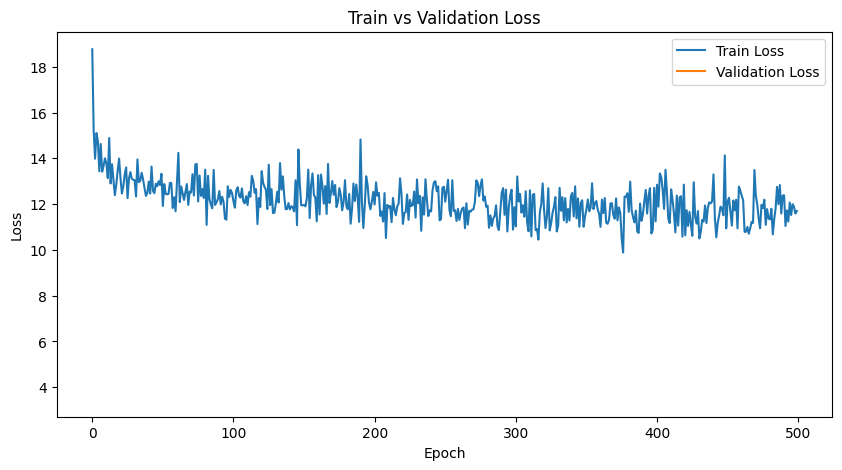

In [92]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(train_loss, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train vs Validation Loss")
plt.legend()
plt.show()
